<a href="https://colab.research.google.com/github/Rach4r/Rach4r/blob/main/PROJECT_FINALE_Osagie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Title: Oral mucosal histopathological image classification using deep learning: OSCC vs Normal 

The most common form of oral cancer is oral squamous cell carcinoima (OSCC). It is one of the most prevalent cancers worldwide, with a global incidence of more than 350,000 new cases and 177,000 deaths every year which varies geographically based on environmental risk factors.
In this project, I used transfer learning to classify histopathological images of the oral mucosa as either benign (normal) or cancer (OSCC). I made use of dataset I downloaded from a histopathological repository available on ScienceDirect comprising first and second set.

In [ ]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

In [ ]:
%load_ext tensorboard
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import backend as K
import gc
from sklearn import metrics
from collections import Counter
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

from tqdm import tqdm
from PIL import Image
import requests
import os
import cv2
import glob

import random
from tensorboard.plugins import projector
from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ftmp4cvtmb-1.zip

Archive:  /content/drive/MyDrive/ftmp4cvtmb-1.zip
   creating: Second Set/
   creating: Second Set/400x OSCC Histopathological Images/
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_474.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_393.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_159.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_87.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_195.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_357.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_276.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_438.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_492.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_69.jpg  
  inflating: Second Set/400x OSCC Histopathological Images/OSCC_400x_177.jpg 

In [ ]:
def Plot_any(arr, title = ''):
    """
    Plot several pictures
    """
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

Loading and Preprocessing of data

In [ ]:
# Defining Parameters
IMG_SIZE = 224
CLASSES = 2
BATCH_SIZE = 32

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

In [ ]:
benign_data = np.array(Dataset_loader('/content/drive/MyDrive/Second Set/400x Normal Oral Cavity Histopathological Images',224))

100%|██████████| 201/201 [00:28<00:00,  7.16it/s]


In [ ]:
oscc_data = np.array(Dataset_loader('/content/drive/MyDrive/Second Set/400x OSCC Histopathological Images',224))

100%|██████████| 495/495 [01:05<00:00,  7.56it/s]


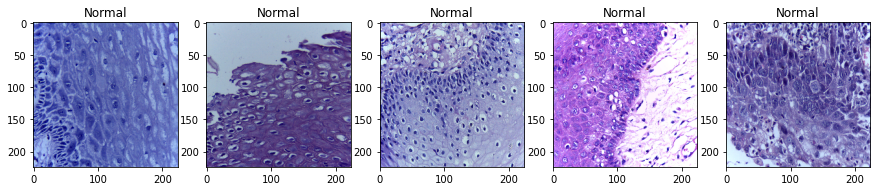

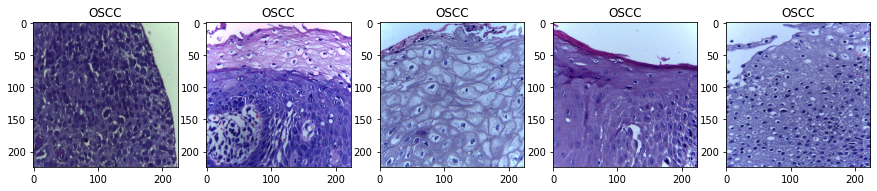

In [ ]:
Plot_any(benign_data[:5], title = "Normal")
Plot_any(oscc_data[:5], title = "OSCC")

Create Labels

In [ ]:
# Oral Cancer: OSCC vs. Normal
# Create labels
benign_label = np.zeros(len(benign_data))
OSCC_label = np.ones(len(oscc_data))

In [ ]:
# Merge data 
X = np.concatenate((benign_data, oscc_data), axis = 0)
Y = np.concatenate((benign_label, OSCC_label), axis = 0)

In [ ]:
# Shuffle data
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

In [ ]:
# To categorical
Y = tf.keras.utils.to_categorical(Y, num_classes= 2)

Train and evaluation split

In [ ]:
#First set of data is used for training
x_train, x_val, y_train, y_val = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=seed_value
)

Display a few images

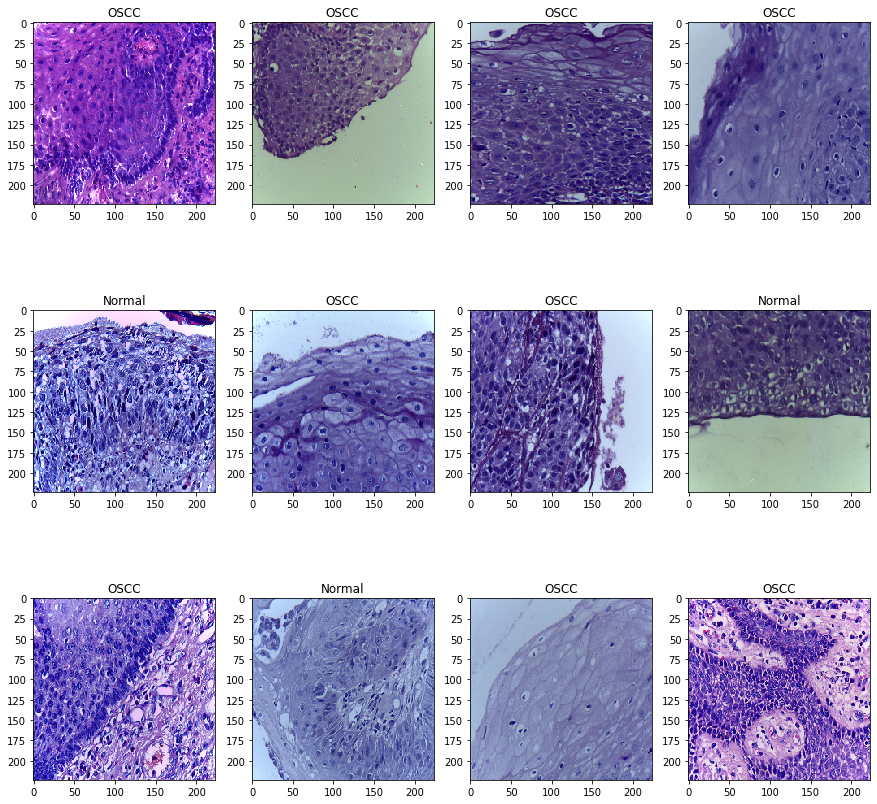

In [ ]:
# # Display first 15 images of the oral mucosa, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('OSCC')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

Data generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

val_generator = val_datagen.flow(x_val,y_val, batch_size=BATCH_SIZE, shuffle= False)

Model

In [ ]:
#Transfer learning using EfficientnetB0 model architecture
base_model = EfficientNetB0(include_top=False,
                  input_shape = (IMG_SIZE,IMG_SIZE,3),
                  weights = 'imagenet')

base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([base_model])
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [ ]:
h = model.fit(train_generator, epochs = 16, verbose = 1, batch_size = 32,
              validation_data  =val_generator,
             callbacks = [es_callback])

Epoch 1/16
18/18 [==============================] - 33s 2s/step - loss: 0.6252 - accuracy: 0.6853 - val_loss: 0.6076 - val_accuracy: 0.6857
Epoch 2/16
18/18 [==============================] - 26s 1s/step - loss: 0.5156 - accuracy: 0.7644 - val_loss: 0.5508 - val_accuracy: 0.7357
Epoch 3/16
18/18 [==============================] - 21s 1s/step - loss: 0.4947 - accuracy: 0.7626 - val_loss: 0.5096 - val_accuracy: 0.7857
Epoch 4/16
18/18 [==============================] - 21s 1s/step - loss: 0.4715 - accuracy: 0.7878 - val_loss: 0.4908 - val_accuracy: 0.7929
Epoch 5/16
18/18 [==============================] - 21s 1s/step - loss: 0.4512 - accuracy: 0.7878 - val_loss: 0.4844 - val_accuracy: 0.7857
Epoch 6/16
18/18 [==============================] - 21s 1s/step - loss: 0.4556 - accuracy: 0.7932 - val_loss: 0.4734 - val_accuracy: 0.7786
Epoch 7/16
18/18 [==============================] - 21s 1s/step - loss: 0.4324 - accuracy: 0.7986 - val_loss: 0.4670 - val_accuracy: 0.7929
Epoch 8/16
18/18 [==

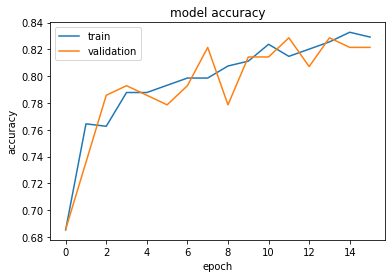

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(h)

In [ ]:
preds = model.evaluate(x_val,y_val )
print('Loss = ' + str(preds[0]))
print('Validation accuracy = ' + str(preds[1]))

5/5 [==============================] - 5s 715ms/step - loss: 0.4059 - accuracy: 0.8214
Loss = 0.4058791399002075
Validation accuracy = 0.8214285969734192


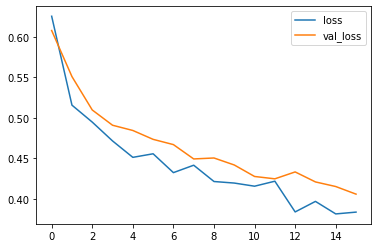

In [ ]:
history_df = pd.DataFrame(h.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
import datetime
#creating a logs directory
log_dir = "logm/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
for layer in model.layers[-3:]:
    layer.trainable = True

In [ ]:
# recompile the model
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), # I use lower learning rate to fine-tune
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

In [ ]:
# fit the model using tensorboard
h_1 = model.fit(train_generator, epochs = 22, verbose = 1, batch_size = 32,
              validation_data =val_generator, initial_epoch = 16, callbacks = [tensorboard_callback])

Epoch 17/22
18/18 [==============================] - 102s 5s/step - loss: 0.7144 - accuracy: 0.5935 - val_loss: 0.4708 - val_accuracy: 0.7786
Epoch 18/22
18/18 [==============================] - 86s 5s/step - loss: 0.4364 - accuracy: 0.8040 - val_loss: 0.4982 - val_accuracy: 0.7929
Epoch 19/22
18/18 [==============================] - 85s 5s/step - loss: 0.3340 - accuracy: 0.8831 - val_loss: 0.4739 - val_accuracy: 0.8071
Epoch 20/22
18/18 [==============================] - 86s 5s/step - loss: 0.2913 - accuracy: 0.8939 - val_loss: 0.4526 - val_accuracy: 0.7929
Epoch 21/22
18/18 [==============================] - 84s 5s/step - loss: 0.2288 - accuracy: 0.9281 - val_loss: 0.4048 - val_accuracy: 0.8286
Epoch 22/22
18/18 [==============================] - 87s 5s/step - loss: 0.2002 - accuracy: 0.9424 - val_loss: 0.4080 - val_accuracy: 0.8143


In [ ]:
preds2 = model.evaluate(x_val,y_val )
print('Loss = ' + str(preds2[0]))
print('Validation accuracy = ' + str(preds2[1]))

5/5 [==============================] - 5s 686ms/step - loss: 0.4080 - accuracy: 0.8143
Loss = 0.4079640209674835
Validation accuracy = 0.8142856955528259


No significant improvement was observed after unfreezing model

In [ ]:
model.save("my_h5_model.h5")

Evaluate in Test data (using second set of images)

In [ ]:
# Testing set (Second set of dataset)
benign_data_test = np.array(Dataset_loader('/content/drive/MyDrive/Second Set/400x Normal Oral Cavity Histopathological Images',224))
oscc_data_test = np.array(Dataset_loader('/content/drive/MyDrive/Second Set/400x OSCC Histopathological Images',224))

100%|██████████| 495/495 [01:05<00:00,  7.55it/s]


In [ ]:
# Oral Cancer: OSCC vs. Normal
# Create labels
benign_test_label = np.zeros(len(benign_data_test))
OSCC_test_label = np.ones(len(oscc_data_test))

In [ ]:
# Merge data 
X_test = np.concatenate((benign_data_test, oscc_data_test), axis = 0)
Y_test = np.concatenate((benign_test_label, OSCC_test_label), axis = 0)

In [ ]:
# Shuffle data
s_test = np.arange(X_test.shape[0])
np.random.shuffle(s_test)
X_test = X_test[s_test]
Y_test = Y_test[s_test]

In [ ]:
# To categorical
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
 y_pred=np.argmax(y_pred, axis=1)

In [ ]:
 y_true=np.argmax(Y_test, axis=1)

In [ ]:
# Import the modules from `sklearn.metrics` 
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

0.8448275862068966

In [ ]:
print(precision_score(y_true, y_pred)) 

print(recall_score(y_true, y_pred)) 

print(f1_score(y_true,y_pred))

0.9754299754299754
0.802020202020202
0.8802660753880266


In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2) 

Confusion matrix, without normalization


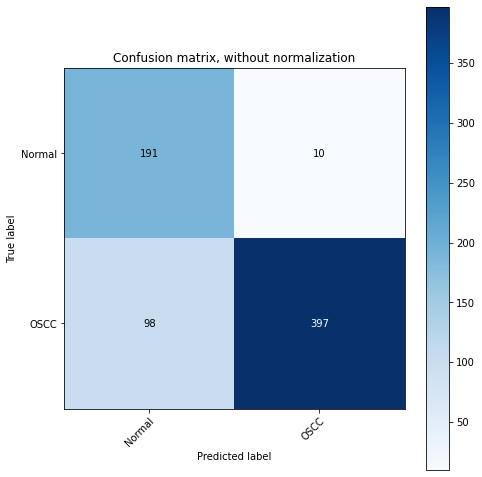

In [ ]:
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['Normal', 'OSCC']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

Normalized confusion matrix


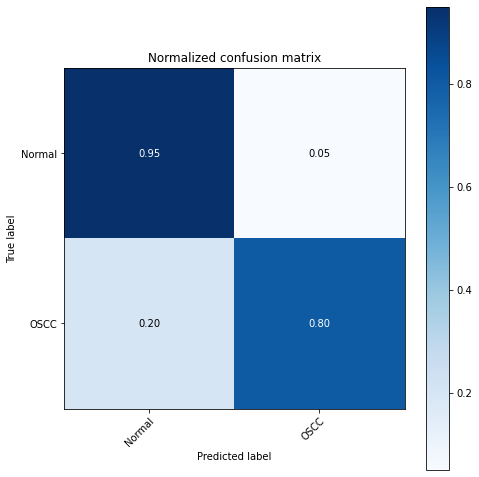

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

My model rightly predicts 80% of OSCC cases and 95% of normal mucosa.

Model Deployment

In [ ]:
!pip install pyngrok==4.1.1
!ngrok authtoken 2EblfS0Nfs3ntgJTUEF5VmiSmaW_7xM2MQrjhKYNNM4zjP3Uo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=33787e1444f463d542494d63c3056fd8d053befd7350c117e167543d1b7fc3a0
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import flask
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import os
from keras.models import load_model 
from keras.preprocessing import image
import numpy as np

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#loading a few test images
img_path1 = "/content/drive/MyDrive/static/images/Normal_400x_1.jpg"
img_path2 = "/content/drive/MyDrive/static/images/OSCC_400x_332.jpg"
img1 = image.load_img(img_path1, target_size=(224, 224))
img2 = image.load_img(img_path2, target_size=(224, 224))

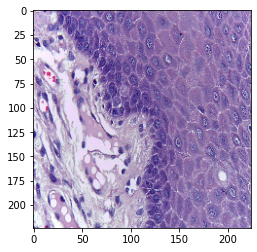

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(img1)
plt.show()

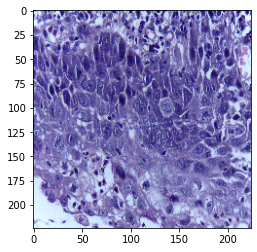

In [ ]:
plt.imshow(img2)
plt.show()

In [ ]:
img_array1 = image.img_to_array(img1)
img_array2 = image.img_to_array(img2)
img_batch1 = np.expand_dims(img_array1, axis=0)
img_batch2 = np.expand_dims(img_array2, axis=0)

In [ ]:
img_preprocessed1 = preprocess_input(img_batch1)
img_preprocessed2 = preprocess_input(img_batch2)

In [ ]:
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib.pyplot import imsave
imsave("/content/drive/MyDrive/images/test1.jpg",img_preprocessed1)
imsave("/content/drive/MyDrive/images/test2.jpg",img_preprocessed2)

In [ ]:
#load model
model = load_model('/content/drive/MyDrive/my_h5_model.h5')

In [ ]:
print(model.predict(img_preprocessed1))
print(model.predict(img_preprocessed2))

[[9.9985385e-01 1.4608653e-04]]
[[0.12759471 0.8724053 ]]


In [ ]:
#create flask app
app = Flask(__name__)
run_with_ngrok(app)   

@app.route("/",methods=['GET'])
def home():
    return render_template('index.html')

In [ ]:
image_folder = os.path.join('/content/drive/MyDrive/static/', '/content/drive/MyDrive/images/')
app.config["UPLOAD_FOLDER"] = image_folder


In [ ]:
@app.route('/', methods=['POST'])
def predict():
  # predicting images
  imagefile = request.files['imagefile']
  image_path = '/content/drive/MyDrive/images/' + imagefile.filename 
  imagefile.save(image_path)

  img = image.load_img(image_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)

  pic = os.path.join(app.config['UPLOAD_FOLDER'], imagefile.filename)
  
  if classes > 0.5:
    return render_template('index.html', user_image=pic, prediction_text='{} patient has OSCC!'.format(imagefile.filename))
  else:
      return render_template('index.html', user_image=pic, prediction_text='{} patient has a normal oral mucosa!'.format(imagefile.filename))

In [ ]:
if __name__ == "__main__":
  app.run()

Resources

Coletta RD, Yeudall WA, Salo T. Grand challenges in oral cancers. Frontiers in Oral Health. 2020 Jun 9;1:3.

Rahman TY, Mahanta LB, Das AK, Sarma JD. Histopathological imaging database for oral cancer analysis. Data in brief. 2020 Apr 1;29:105114.